# Analysis

## Data Exploration and Exploratory Visualization

Some data exploration and exploratory visualization will be performed in order to better understand the data I am dealing with in this Kaggle Competition.

In [2]:
# Import libraries
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Math
from math import floor

%matplotlib inline

In [3]:
# Loading data in Memory
country_data = pd.read_csv("../data/countries.csv")
gender_data = pd.read_csv("../data/age_gender_bkts.csv")

# train data / test data
train_data = pd.read_csv("../data/train_users_2.csv")
target = train_data['country_destination']
test_data = pd.read_csv("../data/test_users.csv")

In [8]:
# Some useful constants
n_train_data = len(train_data)
n_test_data = len(test_data)
print("#training samples: {}".format(n_train_data))

#training samples: 213451


In [4]:
# summary statistics of destination countries in this dataset and their locations
country_data.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [5]:
#  summary statistics of users' age group, gender, country of destination
gender_data.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [6]:
# What are the train data like?
train_data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


* Some data samples are presented in the previous table.

* Some features might need some cleaning
  * Age (a lot of them are NaN and wrong values)
  * Dates - We'll need to parse them and transform them into some other features (seasons, years, ...)

,country_destination_percent
NDF,58.347349
US,29.222632
other,4.728954
FR,2.353233
IT,1.328174
GB,1.088774
ES,1.053638
CA,0.669006
DE,0.497070
NL,0.356991


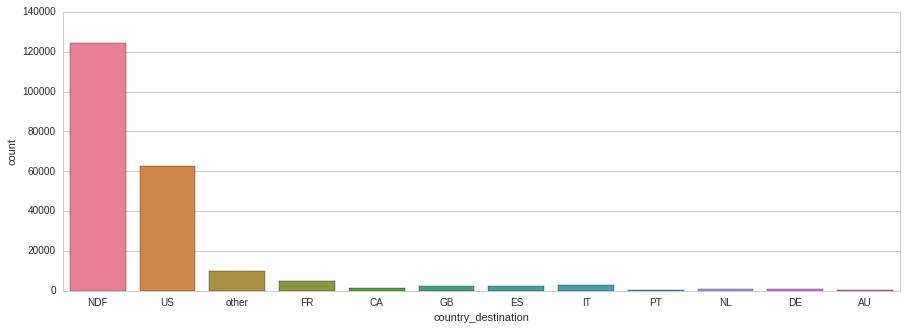

In [9]:
# Let's have a look at the training data
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='country_destination', data=train_data, palette="husl", ax=axis1)

pd.DataFrame({'country_destination_percent' : target.value_counts() * 100 / n_train_data})

The data suggest that

* 58% of the new users do not make any booking.
* 30% book in the US
* 5% are other

It seems that americans tend to prefer traveling in their own country rather than traveling abroad. 

## Benchmark

In order to assess our model's performances, some benchmarks are required.

### Sample submission Benchmark 1

The first idea that comes to mind is to create a classifier that outputs only NDF as predictions. It should provide a simple benchmark for our next iterations. Below is the code used to generate this simple benchmark and writes it in a CSV file so that it can be submitted to Kaggle.

```
def df_submission(ids, f):
    ids_result = []  # list of ids
    cts = []         # list of countries
    for i in range(len(ids)):
        idx = ids[i]
        ids_result += [idx] * 5
        cts += f(i)
    return pd.DataFrame(np.column_stack((ids_result, cts)),
                        columns=['id', 'country'])


def generate_benchmark1_submission(df_train, target, ids):
    df_sub = df_submission(ids, lambda i: ['NDF'])
    df_sub.to_csv(SUBMISSION_PATH + 'benchmark1.csv', index=False)
    return df_sub
```

The NDCG@5 score is: **0.68411** (from Kaggle's scorer)

### Sample submission Benchmark 2

The second benchmark that can be used to assess our model's performance is the following:
Always predict the 5 top country destinations sorted by frequencies (see previous table).
* NDF
* US
* other
* FR
* IT

Here is the code for generating this benchmark and saving it into a csv file:

```
def generate_benchmark2_submission(df_train, target, ids):
    prediction = target.value_counts().index.tolist()[:5]
    df_sub = df_submission(ids, lambda i: prediction)
    df_sub.to_csv(SUBMISSION_PATH + 'benchmark2.csv', index=False)
    return df_sub
```

The NDCG@5 score is: **0.85670** (from Kaggle's scorer)

### Best entry on this competition

The current best entry is scored **0.88697** in the leaderboard. It is relatively close to the sample submission benchmark 2 (score difference of **0.03**).

### Goal

The goal of this project is to create a model that is in between the sample submission benchmark 2 and the best entry in the competition. It means that my model's score should be in the range **[0.85670, 0.88697]**	

## Age
In this section, I will explore and discuss the age data.

In [149]:
# Age exploration
age = train_data['age'].dropna() # A lot of NaN -> fix it with ML?
real_age = age[(age >= 5) & (age <= 95)] # A lot of outliers
print(real_age.describe())

# % of NaNs
percentage_age_NaN = train_data['age'].isnull().sum() * 100 / real_age.describe()['count']
print("% of NaN entries: {0:.1f}%".format(percentage_age_NaN))

count    123011.000000
mean         36.501142
std          11.585328
min           5.000000
25%          28.000000
50%          34.000000
75%          42.000000
max          95.000000
Name: age, dtype: float64
% of NaN entries: 71.5%


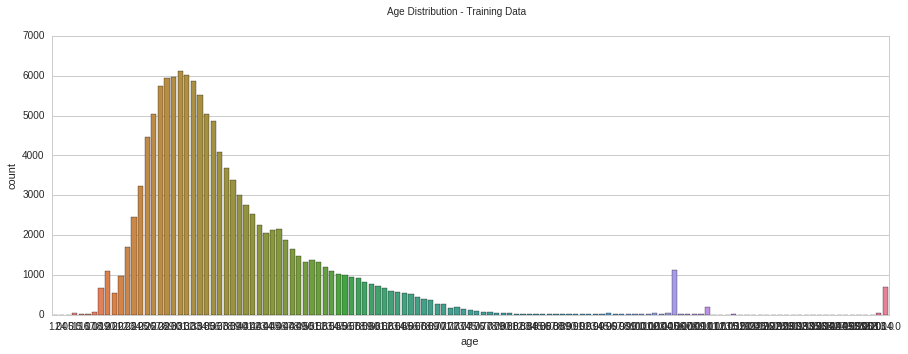

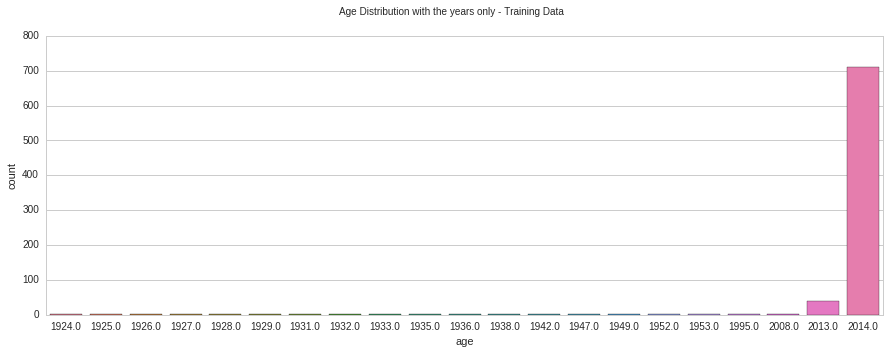

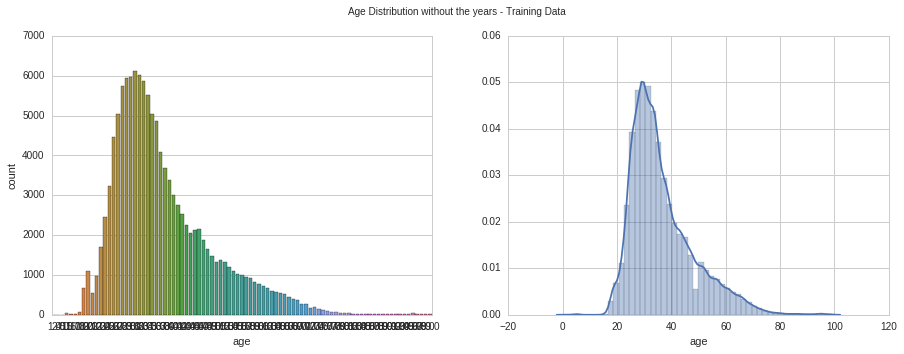

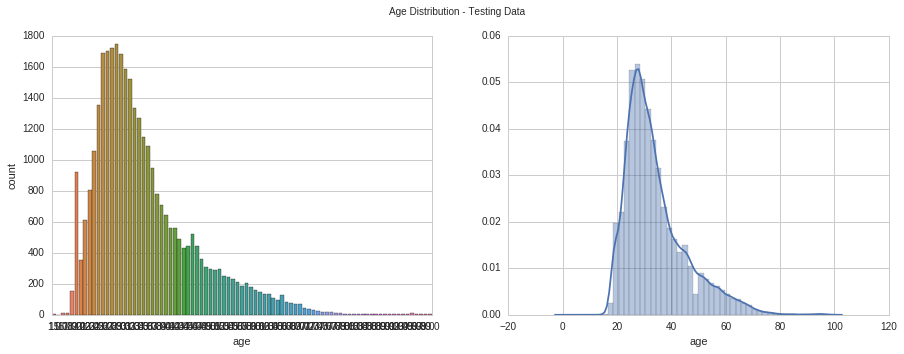

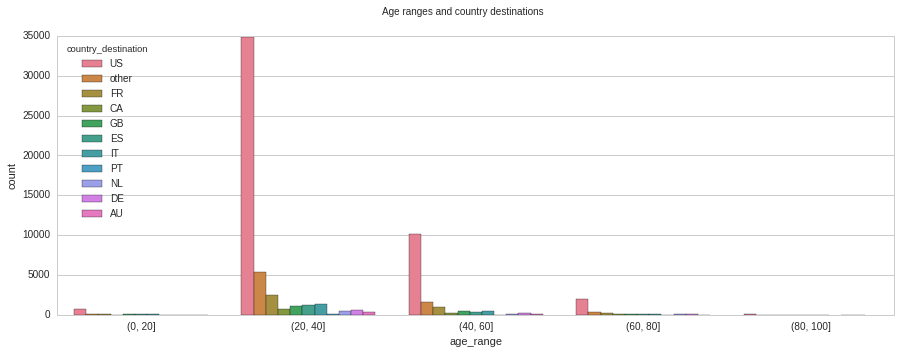

In [201]:
# Exploring the Age Distribution

# Training Data
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
fig.suptitle('Age Distribution - Training Data')
sns.countplot(x='age', data=train_data, palette="husl", ax=axis1)

# Removing the age values
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
fig.suptitle('Age Distribution with the years only - Training Data')
sns.countplot(x='age', data=train_data[train_data['age'] > 300], palette="husl", ax=axis1)

# Removing the year values
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Age Distribution without the years - Training Data')
sns.countplot(x='age', data=train_data[train_data['age'] < 100], palette="husl", ax=axis1)
sns.distplot(train_data[train_data['age'] < 100]['age'], ax=axis2)

# Testing Data
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Age Distribution - Testing Data')
sns.countplot(x='age', data=test_data[test_data['age'] < 100], palette="husl", ax=axis1)
sns.distplot(test_data[test_data['age'] < 100]['age'], ax=axis2)

# cut age values into ranges
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
fig.suptitle('Age ranges and country destinations')
train_data['age_range'] = pd.cut(train_data["age"], [0, 20, 40, 60, 80, 100])
sns.countplot(x="age_range",hue="country_destination", data=train_data[train_data['country_destination'] != 'NDF'], palette="husl", ax=axis1)


I notice that the age data is malformed:
* Sometimes it is an age and sometimes a year date,
* Some values do not make much sense: age <= 5, age >= 95,
* There are a lot of NaN values meaning that these people did not fill out this form input.

Some thoughts on the data
* The age distribution seems close to a **Poisson distribution**,
* Training and testing data follow the same distribution for age. Which is very important for the training and predicting.
* I will need to clean up the data by transforming years

**Cleaning the data**
* Set a valid range (x0, x1) where x0 = 15, x1 = 90
* any values between 1915 and 2000 are birth years
* any age outside the valid range is set to NaN

What is the correlation between users not filling their ages and the destination? Let's have a look.

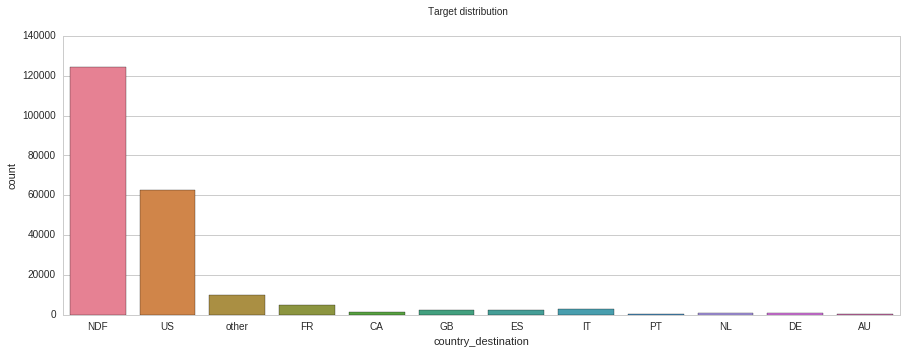

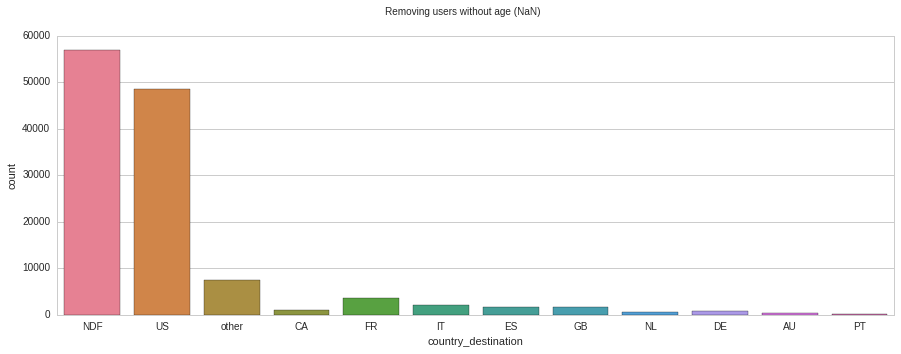

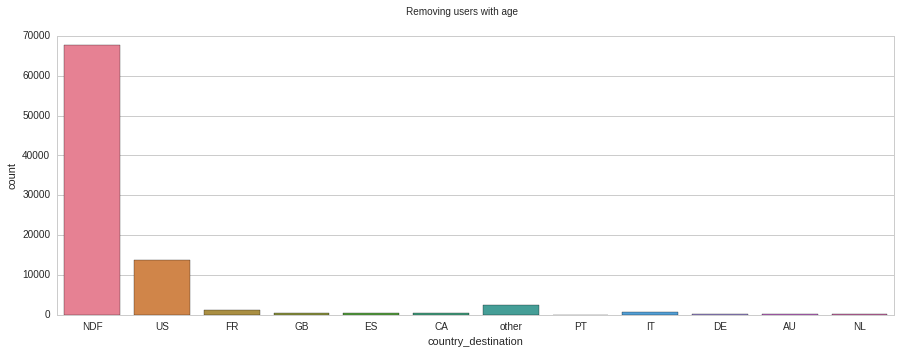

In [151]:
# Without changing the target data
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
fig.suptitle('Target distribution')
sns.countplot(x='country_destination', data=train_data, palette="husl", ax=axis1)

# Removing users without age
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
fig.suptitle('Removing users without age (NaN)')
sns.countplot(x='country_destination', data=train_data[train_data['age'].notnull()], palette="husl", ax=axis1)

# Removing users with age
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
fig.suptitle('Removing users with age')
sns.countplot(x='country_destination', data=train_data[train_data['age'].isnull()], palette="husl", ax=axis1)

From the plots above, the data suggests that only 25% of users with missing ages book while 55% of users with age book a trip.
**NDF** stands for No Destination Found.

## Gender

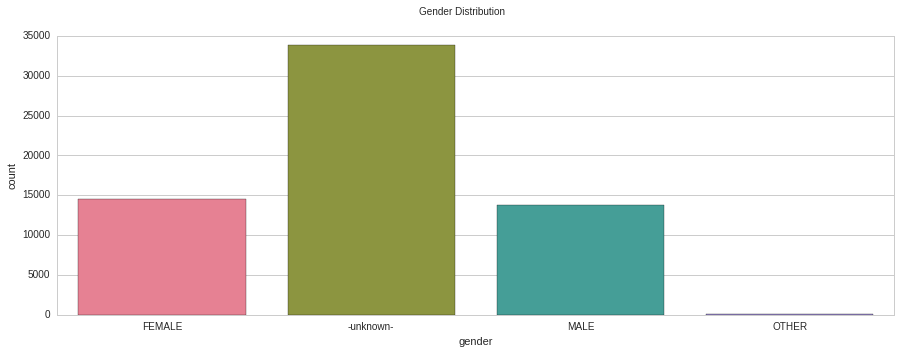

In [153]:
# Gender Exploration
gender = train_data['gender']
gender.value_counts(normalize=True) # How to fix unknown? and OTHER?

fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
fig.suptitle('Gender Distribution')
sns.countplot(x='gender', data=test_data, palette="husl", ax=axis1)

This column needs some cleaning by removing the unknown and other.

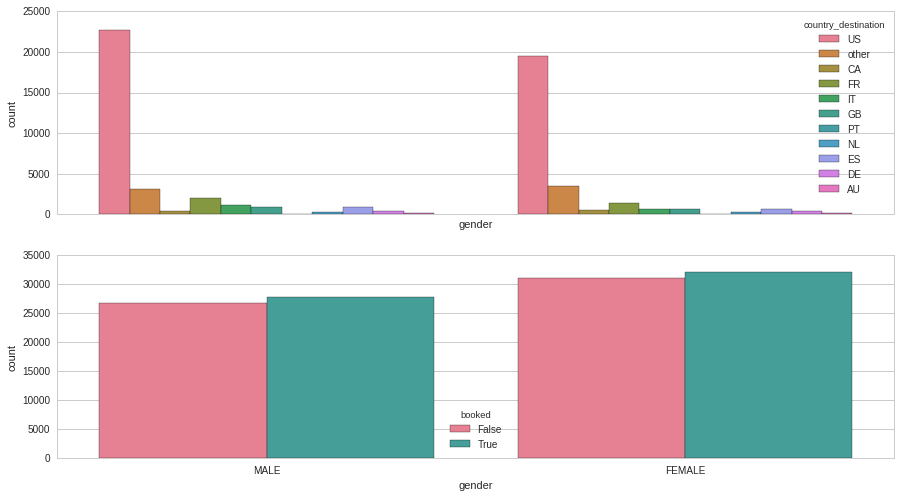

In [154]:
# Keeping only 
train_data_clean_gender = train_data.query('["MALE", "FEMALE"] in gender')
train_data_clean_gender.loc[:, 'booked'] = train_data["country_destination"].apply(lambda x : x != 'NDF')

fig, (axis1, axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))
sns.countplot(x="gender",hue="country_destination", data=train_data_clean_gender[train_data_clean_gender['country_destination'] != 'NDF'], palette="husl", ax=axis1)
sns.countplot(x="gender",hue="booked", data=train_data_clean_gender, palette="husl", ax=axis2)

The data suggests that the gender has no impact on the country destination and if the first destination was booked.

In [169]:
train_data['signup_method'].value_counts(normalize=True)

basic       0.716310
facebook    0.281132
google      0.002558
Name: signup_method, dtype: float64

In [168]:
train_data['first_device_type'].value_counts(normalize=True)

Mac Desktop           0.419768
Windows Desktop       0.340668
iPhone                0.097254
iPad                  0.067177
Other/Unknown         0.049974
Android Phone         0.013132
Android Tablet        0.006053
Desktop (Other)       0.005617
SmartPhone (Other)    0.000356
Name: first_device_type, dtype: float64

In [171]:
train_data['first_browser'].value_counts(normalize=True)

Chrome                  0.299108
Safari                  0.211613
Firefox                 0.157671
-unknown-               0.127739
IE                      0.098702
Mobile Safari           0.090297
Chrome Mobile           0.005950
Android Browser         0.003987
AOL Explorer            0.001148
Opera                   0.000881
Silk                    0.000581
Chromium                0.000342
BlackBerry Browser      0.000248
Maxthon                 0.000216
IE Mobile               0.000169
Apple Mail              0.000169
Sogou Explorer          0.000155
Mobile Firefox          0.000141
SiteKiosk               0.000112
RockMelt                0.000112
Iron                    0.000080
IceWeasel               0.000061
Pale Moon               0.000056
Yandex.Browser          0.000052
SeaMonkey               0.000052
CometBird               0.000052
Camino                  0.000042
TenFourFox              0.000037
wOSBrowser              0.000028
CoolNovo                0.000028
Avant Brow

Some values are not useful if the frequency is too low.
A cleaning step is to remove/change the value if the frequency is under a threshold.

Chrome           0.299108
Safari           0.211613
Firefox          0.157671
-unknown-        0.127739
IE               0.098702
Mobile Safari    0.090297
OHTER            0.014870
Name: first_browser, dtype: float64


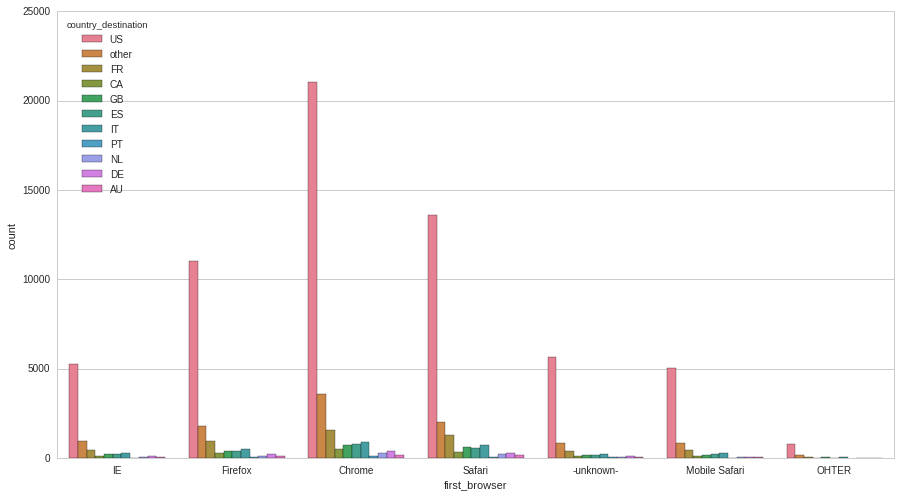

In [190]:
def clean_under_threshold(df, column, f, freq_threshold=.001):
    frequencies = df[column].value_counts(normalize=True)
    return apply_on(df, column, lambda x: f(x) if frequencies[x] < freq_threshold else x)

clean_data_first_browser = clean_under_threshold(train_data, 'first_browser', lambda x: 'OHTER', freq_threshold=.01)
print(clean_data_first_browser['first_browser'].value_counts(normalize=True))

# Plot the first browsers
fig, (axis1) = plt.subplots(1,1,sharex=True,figsize=(15,8))
sns.countplot(x="first_browser",hue="country_destination", data=clean_data_first_browser[clean_data_first_browser['country_destination'] != 'NDF'], palette="husl", ax=axis1)

Web        0.856014
iOS        0.089102
Moweb      0.029332
Android    0.025552
Name: signup_app, dtype: float64


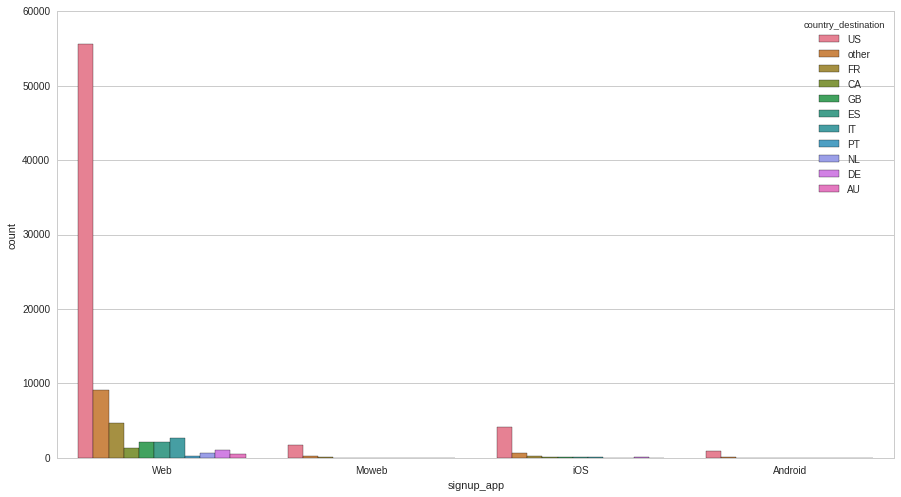

In [188]:
print(train_data['signup_app'].value_counts(normalize=True))

# Plot the signup app
fig, (axis1) = plt.subplots(1,1,sharex=True,figsize=(15,8))
sns.countplot(x="signup_app",hue="country_destination", data=train_data[train_data['country_destination'] != 'NDF'], palette="husl", ax=axis1)

## Algorithms and Techniques

* The trained model will return probabilities for each country destination given a new unseen datapoint. The 5 most likely classes will be used to make a prediction in that order.


* The datasets provided by Kaggle are quite small (they fit in RAM) which makes model training and evaluation simpler since I do not need to use distributed computing or large EC2 instances to handle it.


* Computation will be done on my laptop (at least at the beginning) so that I can iterate faster on the core algorithms and data processing. Later, when hyperparameter tuning is performed, I might need to run it in on an other machine to get it done faster.


With small datasets, batch training can be done and many algorithms can be tested and compared:
* SVMs
* Decision Trees
* Naive Bayes
* ...


### Cleaning and missing values

The age feature is very messy and some cleaning is needed to make use of it. 
* The outliers will be removed,
* The years will be transformed in ages,
* The missing values will be replaced with the collection's mean.


### Feature Engineering

The date features need to be transformed to numbers. Some feature engineering is needed to make that transformation.
We may want to keep or engineer the following:
* Year
* Month
* Day
* Weekday
* Season
* ...

The first step is to use the *train_users.csv* dataset only. If needed, I'll make use of the *sessions.csv* and the other csv files.

### Data Transformation

Some data transformation will be needed:
* Dimensionality reduction (with Principal Componenent Analysis): The training set is not large and the curse of dimensionality can be the root cause for bad performances.
* Data normalization: Some algorithms I want to try require data normalization (SVM and Naive Bayes for instance).

### Boosting methods

Some boosting methods will be used to get better scores. I am planning on trying:
* Random Forests (Adaboost or Bagging),
* Extreme Gradient Boosting - xgboost - that usually works well on Kaggle competitions.